In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

import torch
import torchvision
import torchvision.transforms as transforms

import jax
import jax.numpy as jnp
import optax
from flax.training import train_state

In [32]:
IMAGE_SIZE = 32
BATCH_SIZE = 128
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])
CROP_SCALES = (0.8, 1.0)
CROP_RATIO = (0.9, 1.1)
SEED = 42

plt.style.use('dark_background')

In [33]:
# A helper function that normalizes the images between the values specified by the hyper-parameters.
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img

# A helper function that converts batches into numpy arrays instead of the default option which is torch tensors
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# images in the test set will only be converted into numpy arrays
test_transform = image_to_numpy
# images in the train set will be randomly flipped, cropped, and then converted to numpy arrays
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=CROP_SCALES, ratio=CROP_RATIO),
    image_to_numpy
])

# Validation set should not use train_transform.
train_dataset = torchvision.datasets.CIFAR10('data', train=True, transform=train_transform, download=True)
val_dataset = torchvision.datasets.CIFAR10('data', train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(SEED))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(SEED))
test_set = torchvision.datasets.CIFAR10('data', train=False, transform=test_transform, download=True)

train_data_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)
val_data_loader = torch.utils.data.DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)
test_data_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [34]:
print(f'number of samples in train_set:         {len(train_set)}')
print(f'number of batches in train_data_loader: {len(train_data_loader)}')
print(f'number of samples / batch size:         {len(train_set)} / {BATCH_SIZE} = {len(train_set)/BATCH_SIZE}')
print(f'number of samples in test_set:          {len(test_set)}')
print(f'number of batches in test_data_loader:  {len(test_data_loader)}')
print(f'number of samples / batch size:         {len(test_set)} / {BATCH_SIZE} = {len(test_set)/BATCH_SIZE}')

number of samples in train_set:         45000
number of batches in train_data_loader: 351
number of samples / batch size:         45000 / 128 = 351.5625
number of samples in test_set:          10000
number of batches in test_data_loader:  79
number of samples / batch size:         10000 / 128 = 78.125


In [35]:
print(f'size of images in the first train batch: {next(iter(train_data_loader))[0].shape}')
print(f'type of images in the first train batch: {next(iter(train_data_loader))[0].dtype}')
print(f'size of labels in the first train batch: {next(iter(train_data_loader))[1].shape}')
print(f'type of labels in the first train batch: {next(iter(train_data_loader))[1].dtype}')

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


size of images in the first train batch: (128, 32, 32, 3)
type of images in the first train batch: float64
size of labels in the first train batch: (128,)
type of labels in the first train batch: int64


# Training

In [36]:
from model import CNN
import orbax.checkpoint
from flax.training import orbax_utils

ckpt_dir = '/tmp/flax_ckpt'

model = CNN(outputs=10)
optimizer = optax.adam(learning_rate=1e-4)
rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(SEED), 3)
params = model.init(jax.random.PRNGKey(SEED), jax.random.normal(inp_rng, (BATCH_SIZE, 32, 32, 3)))
model_state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()


In [37]:
@jax.jit
def apply_model(state, images, labels):
    def loss_fn(params):
        prediction = state.apply_fn(params, images)
        one_hot = jax.nn.one_hot(labels, prediction.shape[1])
        loss = jnp.mean(optax.softmax_cross_entropy(logits=prediction, labels=one_hot))

        return loss, prediction

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, prediction), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(prediction, -1) == labels)

    return grads, loss, accuracy

In [38]:
def train_epoch(state, data_loader):
    epoch_loss = []
    epoch_accuracy = []

    for batch in data_loader:
        batch_images, batch_labels = batch
        grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
        state = state.apply_gradients(grads=grads)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)

    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)

    return state, train_loss, train_accuracy

In [39]:
import orbax.checkpoint

def train_model(state, train_data_loader, num_epochs):
    for epoch in range(num_epochs):
        state, train_loss, train_accuracy = train_epoch(state, train_data_loader)
        print(f'epoch: {epoch:03d}, train loss: {train_loss:.4f}, train accuracy: {train_accuracy:.4f}')

    return state

In [40]:
from IPython.display import Javascript  # Restrict height of output cell.

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
trained_model_state = train_model(model_state, train_data_loader, num_epochs=3)

<IPython.core.display.Javascript object>

epoch: 000, train loss: 1.6875, train accuracy: 0.4033
epoch: 001, train loss: 1.4259, train accuracy: 0.4989
epoch: 002, train loss: 1.3401, train accuracy: 0.5304


# Testing

In [41]:
test_loss = []
test_accuracy = []

for batch in test_data_loader:
    batch_images, batch_labels = batch
    _, loss, accuracy = apply_model(trained_model_state, batch_images, batch_labels)
    test_loss.append(loss)
    test_accuracy.append(accuracy)

print(f'loss: {np.mean(test_loss):.4f}, accuracy: {np.mean(test_accuracy):.4f}')

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


loss: 1.2734, accuracy: 0.5528


In [42]:
all_labels, all_pred_labels = [], []
for batch in test_data_loader:
    batch_images, batch_labels = batch
    logits = trained_model_state.apply_fn(trained_model_state.params, batch_images)
    pred_labels = jnp.argmax(logits, axis=1)
    all_labels.append(batch_labels)
    all_pred_labels.append(pred_labels)

all_labels_np = all_labels[0]
all_pred_labels_np = all_pred_labels[0]
for i in range(1,len(all_labels)):
    all_labels_np = np.concatenate((all_labels_np, all_labels[i]), axis=0)
    all_pred_labels_np = np.concatenate((all_pred_labels_np, all_pred_labels[i]), axis=0)

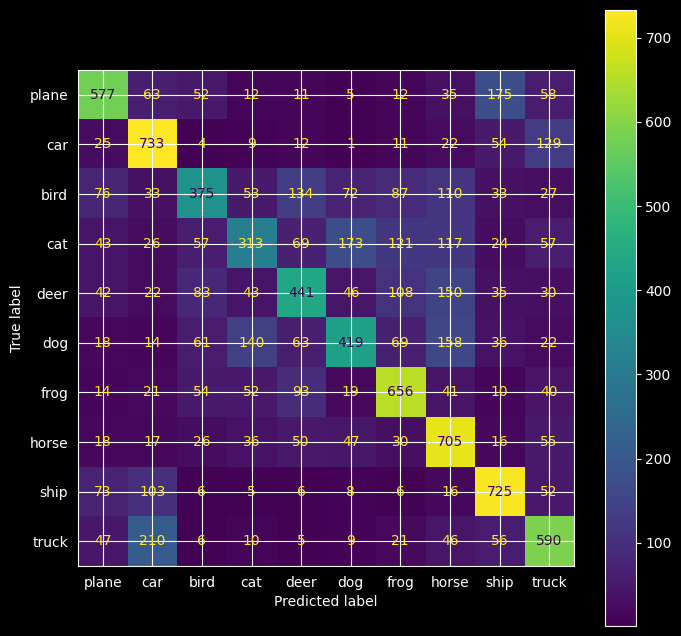

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(all_labels_np, all_pred_labels_np, display_labels=classes, ax=ax)
plt.show()